# 사용데이터

- 전국 및 서울시 코로나19 확진자 수 추이 데이터 - Time.csv, TimeProvince.csv
- 서울시 행정동코드 데이터 - adstrd_master.csv
- 서울시 자치구별 유동인구 데이터 - fpop.csv
- 서울시 자치구별 품목별 소비지수 데이터 - index.csv

In [1]:
# 분석용 라이브러리
# !pip install -U plotly

import pandas as pd
import numpy as np
# pd.options.plotting.backend = 'plotly'

# import plotly
# import plotly.io as pio
# pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import urllib, json
import folium

import warnings
warnings.filterwarnings("ignore")

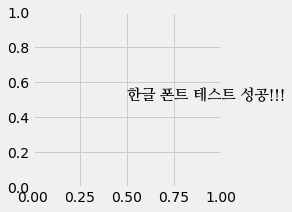

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'
fontprop = fm.FontProperties(fname=fontpath, size=18)


## Test
plt.figure(figsize=(3,3))
plt.text(0.5, 0.5, '한글 폰트 테스트 성공!!!', size=15, fontproperties=fontprop)
plt.show()

In [5]:
# 데이터 준비
# 전국 및 서울시 코로나19 확진자 수 추이 데이터
def covid_preprocessing(df):
    df.columns=['날짜', '확진자수']
    df['날짜'] = pd.to_datetime(df['날짜'])
    df['확진자수_전일'] = [0] + df['확진자수'].iloc[:-1].tolist()
    df['확진자수_신규'] = df['확진자수'] - df['확진자수_전일']

    pre_weeks_df = pd.DataFrame(pd.date_range(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-01-19')),
                              columns=['날짜'])
    df = pd.merge(pre_weeks_df, df, 'outer', '날짜').fillna(0)

    df['월'] = df['날짜'].dt.month
    df['주차'] = df['날짜'].dt.weekofyear
    df = df.groupby(['월', '주차'])['확진자수_신규'].sum().reset_index().astype(int)
    return df

In [6]:
covid_seoul = pd.read_csv('../data/COVID_19/TimeProvince.csv', usecols=['date', 'province', 'confirmed'])
covid_seoul = covid_seoul[covid_seoul.province=='서울'].drop(columns='province')
covid_korea = pd.read_csv('../data/COVID_19/Time.csv', usecols=['date', 'confirmed'])

covid_df = pd.merge(covid_preprocessing(covid_seoul), covid_preprocessing(covid_korea),
                    'outer', ['월', '주차'], suffixes=('_서울', '_전국'))

print('\n\n>>> covid_df.shape :', covid_df.shape)
print('결측치 수 : ', covid_df.isna().sum().sum())
display(pd.concat([covid_df.head(1), covid_df.tail(1)]))



>>> covid_df.shape : (31, 4)
결측치 수 :  0


,월,주차,확진자수_신규_서울,확진자수_신규_전국
0,1,1,0,0
30,6,27,14,85


In [7]:
# 서울시 행정동코드 데이터
dong_df = pd.read_csv('../data/adstrd_master.csv')
dong_df.columns = ['행정동코드', '행정동명', '시도명', '자치구명']
dong_df = dong_df.loc[dong_df.시도명=='서울특별시', ['행정동코드', '자치구명']]
dong_df['행정동코드'] = dong_df['행정동코드'].astype(int)

print('\n\n>>> dong_df.shape :', dong_df.shape)
print('결측치 수 : ', dong_df.isna().sum().sum())
display(pd.concat([dong_df.head(1), dong_df.tail(1)]))



>>> dong_df.shape : (425, 2)
결측치 수 :  0


,행정동코드,자치구명
0,11110515,종로구
424,11740700,강동구


In [8]:
# 서울시 자치구별 유동인구 데이터
# fpop_df['연령대'] = fpop_df['연령대'].apply(lambda x : f'{x}~{int(x[-2:])+9}' if x=='age_00' else f'{x}~' if x=='age_70' else f'{x}~{int(x[-2:])+4}')
fpop_df = pd.read_csv('../data/fpopl.csv', usecols=['base_ymd', 'adstrd_code', 'popltn_cascnt'])
fpop_df.columns = ['기준일', '행정동코드', '유동인구수']
fpop_df = fpop_df.merge(dong_df, how='left', on='행정동코드').drop(columns='행정동코드')  # 자치구명 추가
fpop_df['주차'] = pd.to_datetime(fpop_df['기준일'], format='%Y%m%d').dt.weekofyear

print('\n\n>>> fpop_df.shape :', fpop_df.shape)
print('결측치 수 : ', fpop_df.isna().sum().sum())
display(pd.concat([fpop_df.head(1), fpop_df.tail(1)]))



>>> fpop_df.shape : (47546443, 4)
결측치 수 :  0


,기준일,유동인구수,자치구명,주차
0,20200101,15,서초구,1
47546442,20200616,63,도봉구,25


In [9]:
# 서울시 자치구별 품목별 소비지수 데이터
index_df = pd.read_csv('../data/index.csv').drop(columns='sido')

print('\n\n>>> index_df.shape :', index_df.shape)
print('결측치 수 : ', index_df.isna().sum().sum())
display(pd.concat([index_df.head(1), index_df.tail(1)]))



>>> index_df.shape : (127525, 7)
결측치 수 :  0


,period,catl,catm,age,gender,sigungu,cgi
0,201901,건강/의료용품,건강관리용품,20,F,관악구,115.374642
127524,202005,화장품,화장품,all,all,용산구,45.569377
